In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jacfwd, jacrev, hessian
from jax import jit
import matplotlib.pyplot as plt

Generate points based on desired polynomial with some errors

[0.24576553 0.57218745 0.95647938 0.13318512 0.58532955 0.53684705
 0.83637302 0.57174675 0.3806175  0.2021522  0.3105003  0.13369414
 0.78750678 0.55931674 0.71313617 0.32860433 0.36625156 0.33435807
 0.83349036 0.50198334 0.40915545 0.70376093 0.12979148 0.3523158
 0.03451228 0.83835829 0.00117786 0.67846445 0.43949597 0.94633941
 0.88585315 0.06592845 0.30728388 0.48536803 0.05712054 0.56113704
 0.80857729 0.21065118 0.61855904 0.56222765 0.84935969 0.39078343
 0.75585376 0.80433032 0.58603138 0.92188938 0.32159689 0.43361631
 0.52011229 0.87199437 0.38891987 0.07156612 0.49534649 0.79605793
 0.58505728 0.1074419  0.72142809 0.09027475 0.86816928 0.90949585
 0.36347245 0.53988071 0.45056425 0.07447602 0.57927862 0.81723564
 0.54526215 0.35622121 0.13053385 0.12812081 0.46907163 0.2144285
 0.20999787 0.94943355 0.13542934 0.31944685 0.71005127 0.1879082
 0.71409222 0.81961577 0.8005407  0.66058398 0.42898635 0.53805194
 0.8975993  0.9435258  0.84358378 0.21682376 0.87400641 0.9978773

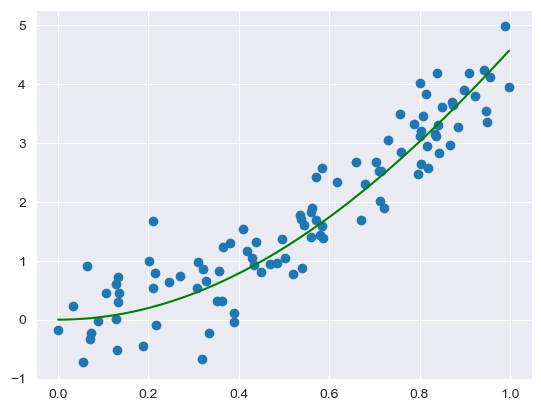

In [11]:
def function(x):
    return 10*jnp.cos(x+3.14)+10

def generate_points(n, error):
    X = np.random.rand(n)
    Y = function(X) + error*np.random.randn(n)
    return X, Y

X, Y = generate_points(100, 0.5)
#plot the function as well
X_org = jnp.linspace(min(X), max(X), 100)
Y_org = function(X_org)
plt.plot(X_org, Y_org, color='green', label='Function')
plt.scatter(X, Y)
print(X)
print(Y)

## Polynomial regression using Newton's method

In [12]:
def predict(params, X):
    #third polynomial
    return params[0] + params[1] * X + params[2] * X ** 2

# Define the loss function (mean squared error)
def loss(params, X, Y):
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2)

# Compute the gradient and Hessian of the loss function
grad_loss = jit(grad(loss))
hessian_loss = hessian(loss)

# Newton's method for polynomial regression
def newton_method(X, Y, num_iterations=10, tol=1e-6,reg=1e-4):
    #random initialization of the parameters using random function from np
    params = np.random.rand(3)
    for i in range(num_iterations):
        grad_l = grad_loss(params, X, Y)
        hess_l = hessian_loss(params, X, Y)
        print(hess_l)
        # Check if the Hessian is invertible
        #hess_l += reg * jnp.eye(len(params))
        if jnp.linalg.cond(hess_l) < 1 / jnp.finfo(hess_l.dtype).eps:
            print(jnp.linalg.inv(hess_l))
            params_new = params - jnp.linalg.solve(hess_l, grad_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton(X, Y):
    params = newton_method(X, Y)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    plt.ylim(-10, 10)
    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='red', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

[[1.9999999  1.0697525  0.72739494]
 [1.0697525  0.7273949  0.547695  ]
 [0.72739494 0.547695   0.4363669 ]]
[[   5.7970743  -22.739256    18.877272 ]
 [ -22.739264   114.21492   -105.44915  ]
 [  18.877275  -105.44916    103.176346 ]]
Iteration 1, Parameters: [-0.00763136  0.8489906   3.6743464 ]
[[1.9999999  1.0697525  0.72739494]
 [1.0697525  0.7273949  0.547695  ]
 [0.72739494 0.547695   0.4363669 ]]
[[   5.7970743  -22.739256    18.877272 ]
 [ -22.739264   114.21492   -105.44915  ]
 [  18.877275  -105.44916    103.176346 ]]
Iteration 2, Parameters: [-0.00763332  0.84900343  3.6743336 ]
[[1.9999999  1.0697525  0.72739494]
 [1.0697525  0.7273949  0.547695  ]
 [0.72739494 0.547695   0.4363669 ]]
[[   5.7970743  -22.739256    18.877272 ]
 [ -22.739264   114.21492   -105.44915  ]
 [  18.877275  -105.44916    103.176346 ]]
Iteration 3, Parameters: [-0.00763311  0.8490025   3.6743343 ]
[[1.9999999  1.0697525  0.72739494]
 [1.0697525  0.7273949  0.547695  ]
 [0.72739494 0.547695   0.43636

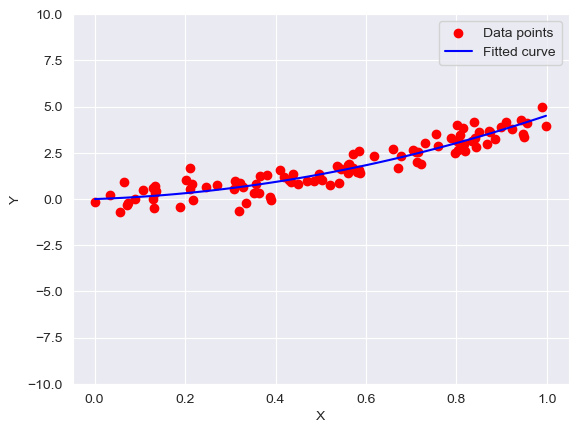

In [13]:
X_init_fit,Y_init_fit,error_init_fit = showNewton(X,Y)

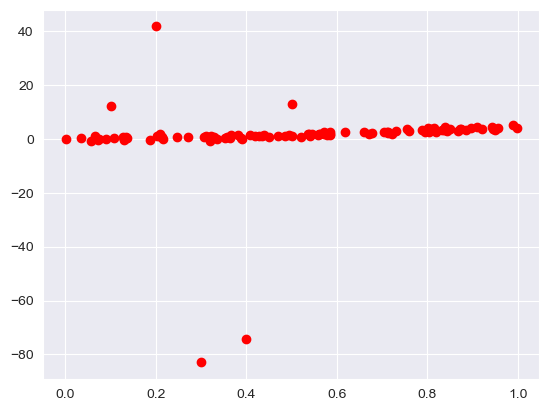

In [14]:
#Add outliers
X_outliers = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
Y_outliers = function(X_outliers) + 50*np.random.randn(len(X_outliers))
X_ol = np.concatenate((X, X_outliers))
Y_ol = np.concatenate((Y, Y_outliers))
#plot
plt.scatter(X_ol, Y_ol, color='red', label='Data points')

[[2.         1.0473834  0.70323324]
 [1.0473834  0.7032333  0.5259    ]
 [0.70323324 0.5259     0.41745228]]
[[   5.7139606  -22.660896    18.9222   ]
 [ -22.660892   114.432915  -105.986664 ]
 [  18.922203  -105.98667    104.03984  ]]
Iteration 1, Parameters: [  1.6432616 -15.571473   20.901623 ]
[[2.         1.0473834  0.70323324]
 [1.0473834  0.7032333  0.5259    ]
 [0.70323324 0.5259     0.41745228]]
[[   5.7139606  -22.660896    18.9222   ]
 [ -22.660892   114.432915  -105.986664 ]
 [  18.922203  -105.98667    104.03984  ]]
Iteration 2, Parameters: [  1.6432815 -15.5715685  20.901709 ]
[[2.         1.0473834  0.70323324]
 [1.0473834  0.7032333  0.5259    ]
 [0.70323324 0.5259     0.41745228]]
[[   5.7139606  -22.660896    18.9222   ]
 [ -22.660892   114.432915  -105.986664 ]
 [  18.922203  -105.98667    104.03984  ]]
Iteration 3, Parameters: [  1.6432793 -15.571558   20.9017   ]
[[2.         1.0473834  0.70323324]
 [1.0473834  0.7032333  0.5259    ]
 [0.70323324 0.5259     0.41745

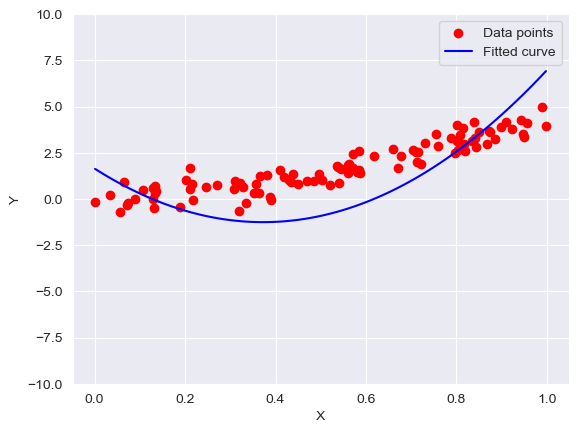

In [15]:
X_ol_fit,Y_ol_fit,error_ol_fit = showNewton(X_ol,Y_ol)

Text(0, 0.5, 'Y')

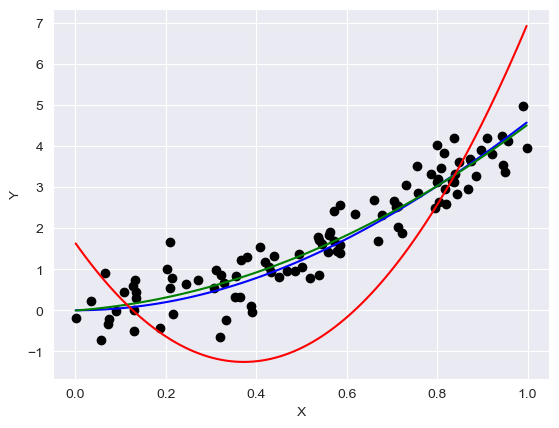

In [16]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_init_fit,Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.scatter(X, Y, color='black', label='Data points')
plt.xlabel('X')
plt.ylabel('Y')

In [17]:
def GaussianCalc(X):
    ave = jnp.mean(X)
    std = jnp.std(X)
    return 1/(std*jnp.sqrt(2*jnp.pi))*jnp.exp(-0.5*((X-ave)/std)**2)

In [18]:
def GaussianCurve(error):
    X_axis = jnp.linspace(-1.5*jnp.max(jnp.abs(error)), 1.5*jnp.max(jnp.abs(error)), 100)
    #Gaussian curve
    Y_axis = GaussianCalc(X_axis)
    #Plot the error distribution
    plt.plot(X_axis, Y_axis)
    #plot the vertical line for each one of the actual error value
    for i in range(len(error)):
        plt.axvline(error[i], color='red')
    
    std = jnp.std(error)
    #plot the axvline for the outlier threshold
    plt.axvline(2*std, color='green')
    plt.axvline(-2*std, color='green')

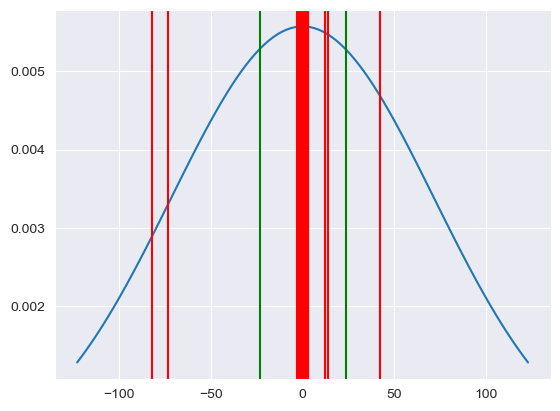

In [19]:
GaussianCurve(error_ol_fit)

In [20]:
#remove outlier based on the gaussian curve
def removeOutliers(X, Y, error):
    ave = jnp.mean(error)
    std = jnp.std(error)
    X_new = []
    Y_new = []
    counter = 0
    for i in range(len(error)):
        if error[i] < 2*std and error[i] > -2*std:
            counter+=1
            X_new.append(X[i])
            Y_new.append(Y[i])
    print(f"Number of outliers removed: {len(error)-counter}")
    return jnp.array(X_new), jnp.array(Y_new)

Number of outliers removed: 3
[[2.         1.0605419  0.71823037]
 [1.0605419  0.71823037 0.5394265 ]
 [0.71823037 0.53942645 0.42903817]]
[[   5.6314635  -22.168678    18.445175 ]
 [ -22.168667   112.26017   -104.03247  ]
 [  18.445158  -104.03243    102.25192  ]]
Iteration 1, Parameters: [ 0.6591596  -0.19298574  4.007003  ]
[[2.         1.0605419  0.71823037]
 [1.0605419  0.71823037 0.5394265 ]
 [0.71823037 0.53942645 0.42903817]]
[[   5.6314635  -22.168678    18.445175 ]
 [ -22.168667   112.26017   -104.03247  ]
 [  18.445158  -104.03243    102.25192  ]]
Iteration 2, Parameters: [ 0.6591636 -0.1930061  4.0070214]
[[2.         1.0605419  0.71823037]
 [1.0605419  0.71823037 0.5394265 ]
 [0.71823037 0.53942645 0.42903817]]
[[   5.6314635  -22.168678    18.445175 ]
 [ -22.168667   112.26017   -104.03247  ]
 [  18.445158  -104.03243    102.25192  ]]
Iteration 3, Parameters: [ 0.65916276 -0.19300194  4.0070176 ]
[[2.         1.0605419  0.71823037]
 [1.0605419  0.71823037 0.5394265 ]
 [0.

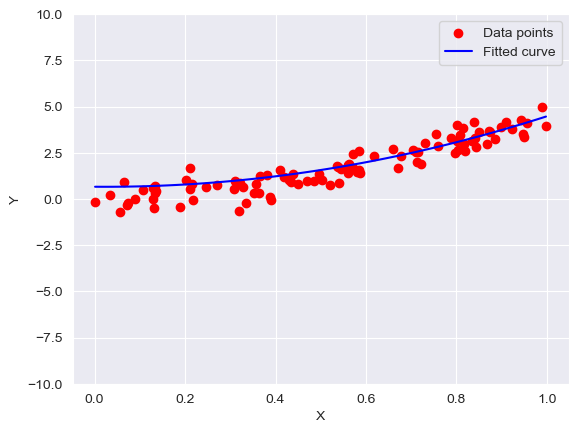

In [21]:
X_new, Y_new = removeOutliers(X_ol, Y_ol, error_ol_fit)
X_ol_removed_fit,Y_ol_removed_fit,error_ol_removed_fit = showNewton(X_new,Y_new)

Text(0, 0.5, 'Y')

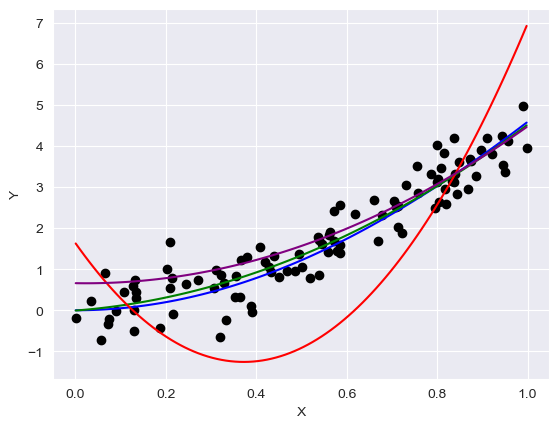

In [22]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_init_fit,Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_ol_removed_fit,Y_ol_removed_fit, color='purple', label='Fitted curve with outliers removed')
plt.scatter(X, Y, color='black', label='Data points')
plt.xlabel('X')
plt.ylabel('Y')

In [23]:
#Create the weighted loss function
def weighted_loss(params, X, Y, error):
    #for each point multiply the error by the corresponding y value of the gaussian curve
    weighted_error = jnp.abs(error*GaussianCalc(error) ** 20)
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2 * weighted_error)

In [24]:
# Compute the gradient and Hessian of the loss function
grad_weighted_loss = jit(grad(weighted_loss))
hessian_weighted_loss = hessian(weighted_loss)

# Newton's method for polynomial regression
def newton_method_weighted(X, Y,error, num_iterations=10, tol=1e-6,reg=1e-4):
    #random initialization of the parameters using random function from np
    params = np.random.rand(3)
    for i in range(num_iterations):
        grad_weighted_l = grad_weighted_loss(params, X, Y,error)
        hess_weighted_l = hessian_weighted_loss(params, X, Y,error)
        print(hess_weighted_l)
        # Check if the Hessian is invertible
        #hess_l += reg * jnp.eye(len(params))
        if jnp.linalg.cond(hess_weighted_l) < 1 / jnp.finfo(hess_weighted_l.dtype).eps:
            print(jnp.linalg.inv(hess_weighted_l))
            params_new = params - jnp.linalg.solve(hess_weighted_l, grad_weighted_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton_weighted(X, Y,error):
    params = newton_method_weighted(X, Y,error)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    plt.ylim(-10, 10)
    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='red', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

[[8.8605853e-30 4.6526145e-30 3.0001048e-30]
 [4.6526145e-30 3.0001048e-30 2.1640998e-30]
 [3.0001048e-30 2.1640998e-30 1.6838123e-30]]
[[ 1.6320876e+30 -5.9454277e+30  4.7333453e+30]
 [-5.9454283e+30  2.6230250e+31 -2.3118946e+31]
 [ 4.7333459e+30 -2.3118949e+31  2.1873682e+31]]
Iteration 1, Parameters: [-0.06255716  1.364701    3.1634789 ]
[[8.8605853e-30 4.6526145e-30 3.0001048e-30]
 [4.6526145e-30 3.0001048e-30 2.1640998e-30]
 [3.0001048e-30 2.1640998e-30 1.6838123e-30]]
[[ 1.6320876e+30 -5.9454277e+30  4.7333453e+30]
 [-5.9454283e+30  2.6230250e+31 -2.3118946e+31]
 [ 4.7333459e+30 -2.3118949e+31  2.1873682e+31]]
Iteration 2, Parameters: [-0.0625586  1.3647082  3.1634724]
[[8.8605853e-30 4.6526145e-30 3.0001048e-30]
 [4.6526145e-30 3.0001048e-30 2.1640998e-30]
 [3.0001048e-30 2.1640998e-30 1.6838123e-30]]
[[ 1.6320876e+30 -5.9454277e+30  4.7333453e+30]
 [-5.9454283e+30  2.6230250e+31 -2.3118946e+31]
 [ 4.7333459e+30 -2.3118949e+31  2.1873682e+31]]
Iteration 3, Parameters: [-0.06255

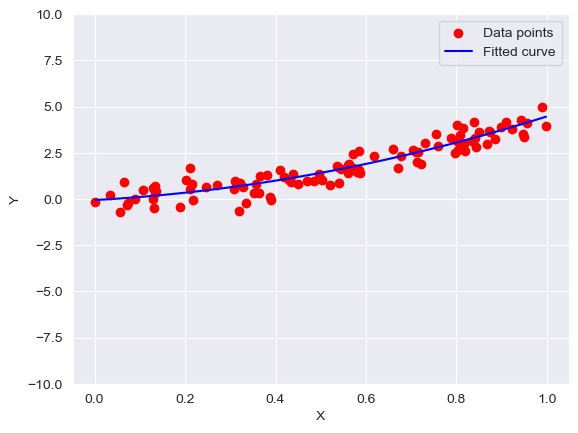

In [25]:
X_ol_weighted_fit,Y_ol_weighted_fit,error_ol_weighted_fit = showNewton_weighted(X_ol,Y_ol,error_ol_fit)

Text(0, 0.5, 'Y')

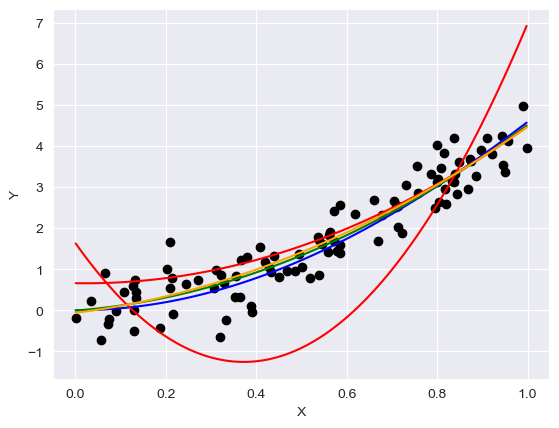

In [27]:
#Cast the original graph and the generated graph
X_comp = jnp.linspace(min(X), max(X), 100)
plt.plot(X_comp,Y_org, color='blue', label='Original function')
plt.plot(X_init_fit,Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_ol_fit,Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_ol_removed_fit,Y_ol_removed_fit, color='red', label='Fitted curve with outliers removed')
plt.plot(X_ol_weighted_fit,Y_ol_weighted_fit, color='orange', label='Fitted curve with weighted loss')
plt.scatter(X, Y, color='black', label='Data points')
plt.xlabel('X')
plt.ylabel('Y')

In [33]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return (jnp.mean((y_true - y_pred) ** 2))

# Generate a common set of X values for comparison
X_comp = jnp.linspace(min(X), max(X), 100)

# Compute RMSE for each fitted curve
rmse_init = float(calculate_rmse(Y_org, Y_init_fit))
rmse_ol = float(calculate_rmse(Y_org, Y_ol_fit))
rmse_ol_removed = float(calculate_rmse(Y_org, Y_ol_removed_fit))
rmse_ol_weighted = float(calculate_rmse(Y_org, Y_ol_weighted_fit))

# Print RMSE values
print(f"RMSE without outliers: {rmse_init}")
print(f"RMSE with outliers: {rmse_ol}")
print(f"RMSE with outliers removed: {rmse_ol_removed}")
print(f"RMSE with weighted loss: {rmse_ol_weighted}")


RMSE without outliers: 0.008106079883873463
RMSE with outliers: 2.146144151687622
RMSE with outliers removed: 0.16387498378753662
RMSE with weighted loss: 0.01827130652964115


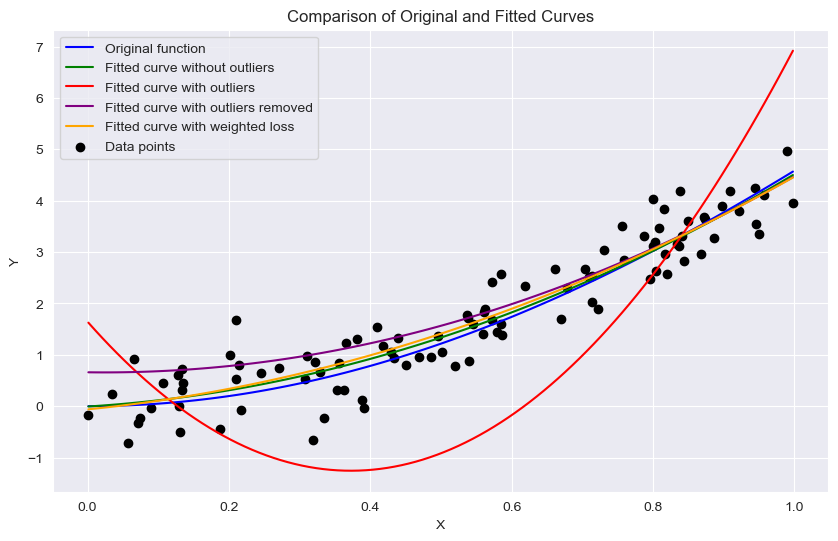

In [34]:
# Plot the original and fitted curves
plt.figure(figsize=(10, 6))
plt.plot(X_comp, Y_org, color='blue', label='Original function')
plt.plot(X_comp, Y_init_fit, color='green', label='Fitted curve without outliers')
plt.plot(X_comp, Y_ol_fit, color='red', label='Fitted curve with outliers')
plt.plot(X_comp, Y_ol_removed_fit, color='purple', label='Fitted curve with outliers removed')
plt.plot(X_comp, Y_ol_weighted_fit, color='orange', label='Fitted curve with weighted loss')
plt.scatter(X, Y, color='black', label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Comparison of Original and Fitted Curves')
plt.show()


In [35]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for the RMSE values
data = {
    'Curve Type': ['Without Outliers', 'With Outliers', 'Outliers Removed', 'Weighted Loss'],
    'RMSE': [rmse_init, rmse_ol, rmse_ol_removed, rmse_ol_weighted]
}

df = pd.DataFrame(data)


df


,Curve Type,RMSE
0,Without Outliers,0.008106
1,With Outliers,2.146144
2,Outliers Removed,0.163875
3,Weighted Loss,0.018271
